<h1>Содержание<span class="tocSkip"></span></h1>


<h1>Промышленность - задача проекта 

**Условие задачи**

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

**Описание этапа обработки**

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша.

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

**Описание данных**

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

Данные находятся в папке `/datasets/final_steel/`.

## Первичный анализ данных

### Импорт данных

In [1]:
# импорт библиотек (позже добавлю необходимые)
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import Image
from IPython.core.display import HTML 

from pyod.models.knn import KNN
from scipy import stats as st
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

In [2]:
# загрузка файлов
data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')

### Схема ковша печи

In [3]:

Image(url= "https://camo.githubusercontent.com/15d8508fd2800420ebed4c4be665b151f30e768c2131445e8509a8c38d36adb1/687474703a2f2f6b6e6f776c656467652e73752f7573657266696c65732f656469746f722f6c617267652f322f31393031345f31313365336234633438333034662d32303365343134313338333934313361333034662d3464336434363338336133623365336633353334333834662d3232336533632d31342d312d3439312e706e67", width=300, height=300)

### Исследование исходных данных

#### Данные об электродах

In [4]:
# посмотрим на данные в таблице
data_arc

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
...,...,...,...,...,...
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768


In [5]:
data_arc.shape

(14876, 5)

In [6]:
# проверим данные на пропуски
data_arc.isna().sum()

key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64

In [7]:
# посмотрим на типы данных
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


>Таблица `data_arc` содержит данные об электродах. В таблице 5 колонок по 14876 строк.

Колонки:
- key (номер партии)
- Начало нагрева дугой
- Конец нагрева дугой
- Активная мощность
- Реактивная мощность

Пропусков в данных нет, 
однако даты хранятся в столбцах с неправильным типом, исправим:

In [8]:
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'])
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'])
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


In [9]:
# посмотрим на статистику значений в столбцах
data_arc.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


- Активная мощность (Real Power) — это полезная часть мощности, та часть, которая определяет прямое преобразования электрической энергии в другие необходимые виды энергии. Фактически, активная мощность определяет скорость полезного потребления энергии. 
Единица измерения — ватт (русское обозначение: Вт, киловатт - кВт; международное: ватт -W, киловатт - kW).

- Реактивная мощность (Reactive Power)— мощность определяемая электромагнитными полями, образующимися в процессе работы приборов. Реактивная мощность, как правило, является «вредной» или «паразитной». Реактивная мощность определяется характером нагрузки.
Единица измерения — вольт-ампер реактивный (русское обозначение: вар, кВАР; международное: var). 

>Интересно, что минимальное значение реактивной мощности - отрицательное. 

По информации из интернета: "... Реактивная мощность может быть как положительной величиной (если нагрузка имеет активно-индуктивный характер), так и отрицательной (если нагрузка имеет активно-ёмкостный характер). Данное обстоятельство подчёркивает тот факт, что реактивная мощность не участвует в работе электрического тока. Когда устройство имеет положительную реактивную мощность, то принято говорить, что оно её потребляет, а когда отрицательную — то производит ..."

>Возможно в нашем случае система, может как производить, так и потреблять реактивную мощность в зависимости от величины тока. За счёт этого осуществляется регулирование уровня температуры стали.

Стоит проверить, много ли отрицательных данных, или это единичный выброс. 


In [10]:
# посмотрим на 5 самых низких значений реактивной мощности
data_arc.sort_values(by = ['Реактивная мощность']).head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924
5596,1216,2019-06-16 08:22:19,2019-06-16 08:22:30,0.030188,0.020806
2419,521,2019-05-22 17:42:57,2019-05-22 17:43:11,0.030563,0.021154
4914,1060,2019-06-11 04:31:57,2019-06-11 04:32:08,0.031630,0.022485
4633,1000,2019-06-09 01:17:44,2019-06-09 01:17:57,0.038186,0.022983


>Такое отрицательное значение одно. Очевидно, что это аномалия, но стоит ли удалять такое значение?  

Сколько итераций нагрева обычно происходит на одну партию:

Text(0.5, 0, 'Количество итераций нагрева в одной партии')

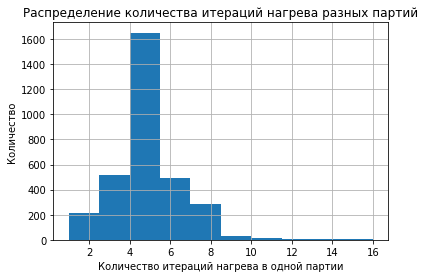

In [11]:
import matplotlib.pyplot as plt
plt.figure()
ax = data_arc.groupby('key')['Активная мощность'].count().hist()
ax.set_title('Распределение количества итераций нагрева разных партий')
ax.set_ylabel('Количество')
ax.set_xlabel('Количество итераций нагрева в одной партии')

>Чаще всего 5 итераций для одной партии.

Посмотрим на гистограммы мощностей нагрева:

Text(0.5, 0, 'Активная мощность')

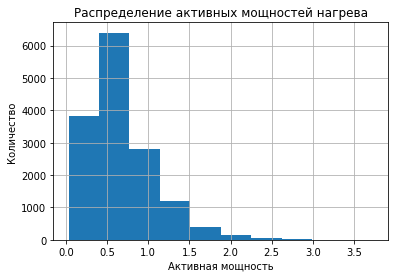

In [12]:
plt.figure()
ax = data_arc['Активная мощность'].hist()
ax.set_title('Распределение активных мощностей нагрева')
ax.set_ylabel('Количество')
ax.set_xlabel('Активная мощность')

Text(0.5, 0, 'Реактивная мощность')

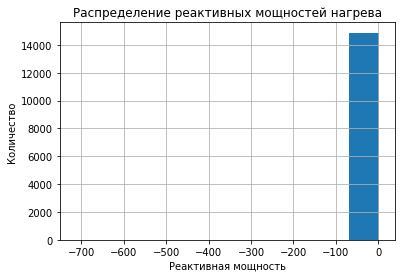

In [13]:
plt.figure()
ax = data_arc['Реактивная мощность'].hist()
ax.set_title('Распределение реактивных мощностей нагрева')
ax.set_ylabel('Количество')
ax.set_xlabel('Реактивная мощность')

>На графике выброс тоже определяется.

>Если удалить этот выброс - удалим целую итерацию нагрева дугой. Это может плохо сказаться на качестве прогноза температуры. Заменить тоже не получится. Учитывая, что реактивная мощность может принимать как положительные так и отрицательные значения то, чтобы разобраться является ли это отрицательное значение аномальным, необходимо уточнить у заказчика(бизнеса)... и если такие значения являются нормой, то удалять не стоит, а если это случается очень редко и/или во время технологического сбоя, то тогда надо удалять... в нашем случае отрицательное значение одно, то предположим, что это выброс и удалим. С другой стороны возможно, что реактивная мощность не влияет на результат нашего исследования, поэтому это значение не важно.

#### Данные о подаче сыпучих материалов (объём, время)

In [14]:
# посмотрим на данные в таблице
data_bulk

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0


In [15]:
data_bulk_time

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,2019-08-31 22:51:28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 22:46:52,NaN,2019-08-31 22:46:52,2019-08-31 22:46:52
3125,3238,NaN,NaN,2019-08-31 23:39:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 23:33:09,NaN,2019-08-31 23:33:09,2019-08-31 23:33:09
3126,3239,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:51:58,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:39:41,NaN,2019-09-01 01:33:25,2019-09-01 01:33:25
3127,3240,NaN,NaN,NaN,NaN,NaN,2019-09-01 03:12:40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-01 02:41:27,2019-09-01 02:41:27


In [16]:
# проверим данные на пропуски
data_bulk.isna().sum()

key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

In [17]:
data_bulk_time.isna().sum()

key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

>Структуры таблиц одинаковы 16 колонок по 3129 строк. Сразу видно в таблицах очень много пропусков, однако пропуски в стоnлбцах `Bulk...n` идентичны. Так как в таблицах содержатся данные об объеме и времени подаче сыпучих материалов, то напрашивается вывод, что в каждой конкретной партии использовались не все сыпучие материалы `Bulk...n`, поэтому и пропуски, которые возможно заменить на 0?

Также возможно стоит объединить эти таблицы и привести даты к датам. 

In [18]:
data_temp['Время замера'] = pd.to_datetime(data_temp['Время замера'])
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           15907 non-null  int64         
 1   Время замера  15907 non-null  datetime64[ns]
 2   Температура   13006 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 372.9 KB


array([[<AxesSubplot:title={'center':'key'}>,
        <AxesSubplot:title={'center':'Bulk 1'}>,
        <AxesSubplot:title={'center':'Bulk 2'}>,
        <AxesSubplot:title={'center':'Bulk 3'}>],
       [<AxesSubplot:title={'center':'Bulk 4'}>,
        <AxesSubplot:title={'center':'Bulk 5'}>,
        <AxesSubplot:title={'center':'Bulk 6'}>,
        <AxesSubplot:title={'center':'Bulk 7'}>],
       [<AxesSubplot:title={'center':'Bulk 8'}>,
        <AxesSubplot:title={'center':'Bulk 9'}>,
        <AxesSubplot:title={'center':'Bulk 10'}>,
        <AxesSubplot:title={'center':'Bulk 11'}>],
       [<AxesSubplot:title={'center':'Bulk 12'}>,
        <AxesSubplot:title={'center':'Bulk 13'}>,
        <AxesSubplot:title={'center':'Bulk 14'}>,
        <AxesSubplot:title={'center':'Bulk 15'}>]], dtype=object)

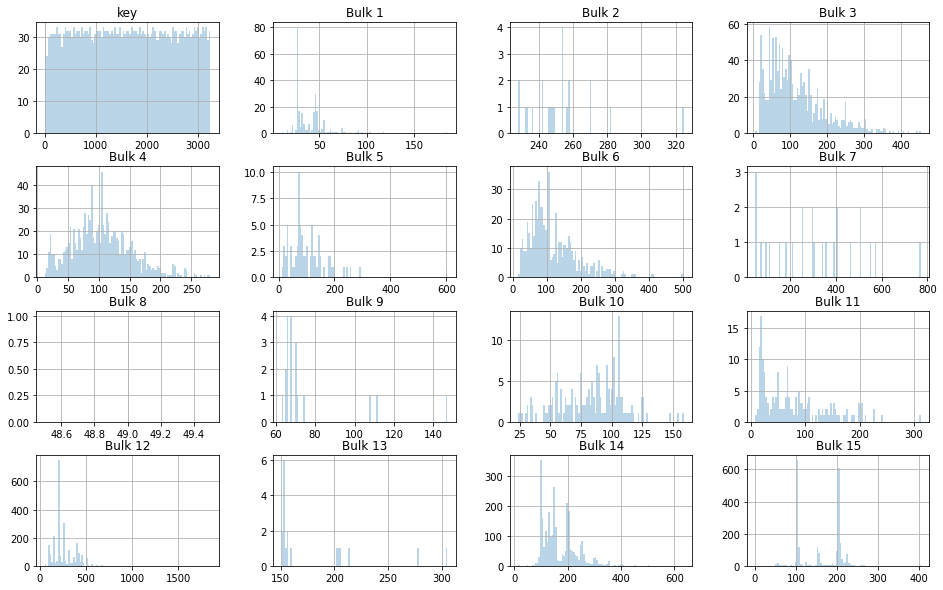

In [19]:
# посмотрим на использование сыпучих материалов
data_bulk.hist(bins=100, figsize=(16,10), alpha=0.3)

>Некоторые материалы либо вообще не использовались ('Bulk 8'), либо мало (редко) использовались ('Bulk 13,1,2,9,7'). Посмотрим подробнее:

Text(0.5, 0, 'Тип сыпучего материала')

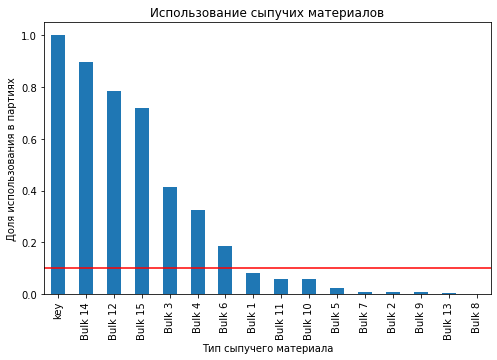

In [20]:
plt.figure(figsize = (8,5))
ax = (~data_bulk_time.isnull()).mean().sort_values(ascending=False).plot(kind = 'bar')
ax.axhline(y=0.1, color='r', linestyle='-')
ax.set_title('Использование сыпучих материалов')
ax.set_ylabel('Доля использования в партиях')
ax.set_xlabel('Тип сыпучего материала')

>Действительно материалы Bulk 1, 11, 10, 5, 7, 2, 9, 13, 8 использовались менее 10%. Что с ними делать? оставить или удалить?

<div class="alert alert-block alert-info">
<b>Комментарий:</b> Здесь также необходимо было бы уточнить у заказчика(бизнеса) действительно ли эти материалы мало(редко) используются... и если да, то удалить эти данные ... НО с другой стороны чистить данные надо аккуратно учитывая, что при обработки стали важен химческий состав сплава и именно легированием корректируется химический состав и отбираются пробы до достижения целевого химического состава и оптимальной температуры плавки. Судя по данным првичный состав стали может быть разным и какие потребуются добавки выясняют в процессе обработки. Поэтому удалять из данных мало(редко) используемые материалы сразу не стоит.
</div>

#### Данные о продувке сплава газом

In [21]:
# посмотрим на данные в таблице
data_gas

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
...,...,...
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103


In [22]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [23]:
data_gas.describe()

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


Text(0.5, 0, 'Значение')

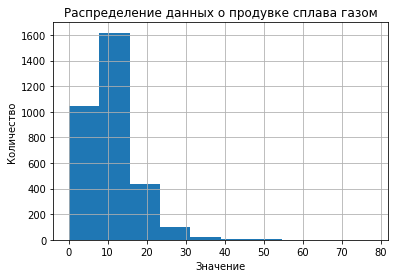

In [24]:
plt.figure()
ax = data_gas['Газ 1'].hist()
ax.set_title('Распределение данных о продувке сплава газом')
ax.set_ylabel('Количество')
ax.set_xlabel('Значение')

>В таблице 2 столбца (key и Газ 1) по 3239 строк. Пропусков нет. Судя по всему в каждой партии по одной продувке сплава газом. Показатели в каждой партии разные в неизвестных единицах измерения, поэтому не понятно есть ли аномалии или выбросы?

#### Результаты измерения температуры

In [25]:
# посмотрим на данные в таблице
data_temp

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
...,...,...,...
15902,3241,2019-09-01 04:03:30,1586.0
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN


In [26]:
# проверим данные на пропуски
data_temp.isna().sum()

key                0
Время замера       0
Температура     2901
dtype: int64

In [27]:
# посмотрим на тип данных
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           15907 non-null  int64         
 1   Время замера  15907 non-null  datetime64[ns]
 2   Температура   13006 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 372.9 KB


In [28]:
# посмотрим на статистику значений в столбцах
data_temp.describe()

,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


>В таблице 3 столбца по 15907 строк. Результаты измерения температуры стали находятся в толбце `Температура`. Есть пропущенные значения температуры и необходимо привести время замера к правильному формату.

In [29]:
data_temp['Время замера'] = pd.to_datetime(data_temp['Время замера'])
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           15907 non-null  int64         
 1   Время замера  15907 non-null  datetime64[ns]
 2   Температура   13006 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 372.9 KB


>Что делать с пропусками? Наша задача - **предсказать температуру стали**. Конечный замер температуры - это целевой признак. Пропущенные значения температуры состаляют 18% от объема даных. Возможно ли удалить пропуски? 

#### Данные о проволочных материалах (объем, время)

In [30]:
# посмотрим на данные в таблице
data_wire

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
# проверим данные на пропуски
data_wire.isna().sum()

key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

In [32]:
# посмотрим на тип данных
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [33]:
# посмотрим на данные в таблице
data_wire_time

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,2019-08-31 22:50:20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,2019-08-31 23:38:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,2019-09-01 01:50:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,2019-09-01 03:12:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
# проверим данные на пропуски
data_wire_time.isna().sum()

key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

In [35]:
# посмотрим на тип данных
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


>Структуры таблиц `data_wire` и `data_wire_time` одинаковы 10 колонок по 3081 строк. Таблицы содержат данные об объеме и дате добавления легирующих добавок в виде проволочных материалов. В таблицах очень много пропусков, однако пропуски в стоnлбцах Wire... идентичны. Непонятно в каких единицах замеряли объем легирующих добавок. Видно, что в партиях использовались не все типы проволочных материалов. 

Посмотрим, если ли проволочные материалы, которые использовались в производстве партий редко:

Text(0.5, 0, 'Тип проволочного материала')

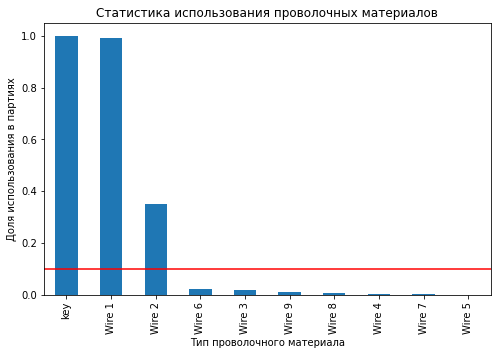

In [36]:
plt.figure(figsize = (8,5))
ax = (~data_wire_time.isnull()).mean().sort_values(ascending=False).plot(kind = 'bar')
ax.axhline(y=0.1, color='r', linestyle='-')
ax.set_title('Статистика использования проволочных материалов')
ax.set_ylabel('Доля использования в партиях')
ax.set_xlabel('Тип проволочного материала')

>Чаще всего использовались проволочные материалы 1 и 2 типа, остальные почти не использовались. Что с ними делать, может удалить? и необходимо привести время добавления легирующих добавок к правильному формату.

<div class="alert alert-block alert-info">
<b>Комментарий:</b> По аналогии с сыпучими материалами сразу удалять из данных мало(редко) используемые материалы сразу не стоит.
</div>

### Посмотрим на все события при изготовлении одной конктерной партии

In [37]:
data_arc.query("key == 1")

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


In [38]:
data_bulk.query("key == 1")

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0


In [39]:
data_gas.query("key == 1") 

,key,Газ 1
0,1,29.749986


In [40]:
data_wire.query("key == 1") 

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
data_temp.query("key == 1")

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


### Вывод по пункту 1

- Таблица `data_arc` содержит данные об электродах 5 колонок по 14876 строк. Пропусков в данных нет, даты хранятся в столбцах с неправильным типом, исправим. Имеется единственное аномальное отрицательное значение реактивной мощности.
- В таблицах `data_bulk` и `data_bulk_time` данные о подаче сыпучих материалов (объём, время). Структуры таблиц одинаковы 16 колонок по 3129 строк. В таблицах много пропусков, пропуски в стоnлбцах Bulk идентичны. В каждой конкретной партии использовались не все сыпучие материалы Bulk, поэтому пропуски, которые возможно заменить на 0. Материалы Bulk 1, 11, 10, 5, 7, 2, 9, 13, 8 использовались менее 10%. Необходим перевод времени в формат datetime.
- В таблице `data_gas` данные о продувке сплава газом 2 столбца по 3239 строк. Пропусков нет. В каждой партии по одной продувке сплава газом. Показатели в каждой партии разные в неизвестных единицах измерения, поэтому не понятно есть ли аномалии или выбросы.
- В таблице `data_temp` результаты измерения температуры 3 столбца по 15907 строк. Конечный замер температуры - это целевой признак. Есть пропущенные значения замера температуры, удалим партии в которых отсутсвует конечная температура и необходимо привести время замера к правильному формату.
- Структуры таблиц `data_wire` и `data_wire_time` одинаковы 10 колонок по 3081 строк. Таблицы содержат данные об объеме и дате добавления легирующих добавок в виде проволочных материалов. В таблицах очень много пропусков, однако пропуски в стоnлбцах Wire... идентичны. Непонятно в каких единицах замеряли объем легирующих добавок. Видно, что в партиях использовались не все типы проволочных материалов, поэтому пропуски, которые возможно заменить на 0. Чаще всего использовались проволочные материалы 1 и 2 типа, остальные использовались менее 10%. Необходим перевод времени в формат datetime.
- Во всех таблицах столбец key содержит номер партии. 
- В таблицах `data_arc` и `data_temp` несколько строк с одинаковым значением key в разное время: они соответствуют разным итерациям обработки.
- Количество записей одной партии для каждой таблицы может различаться.
- Во всех таблицах разноязычные названия столбцов. Имена столбцов нужно превести к английском языку прописными буквами и избавиться от пробелов.


## Подготовка данных

1. Найдем суммы значений активной и реактивной мощности.
2. Найдем все записи по температурам, где есть минимум два значения температуры и создадим новую таблицу из первого и последнего замера.
3. Значения столбца key переведем в индексы датафреймов.
4. Заменим nan значения на 0 для таблиц data_bulk и data_wire.
5. Приведем типы данных.

>Составим из таблицы data_arc сгрупированную таблицу data_arc_sum по key для дальнейшего объединения данных. 

In [42]:
data_arc.columns = ['key', 'start_time','end_time', 'active_power', 'reactive_power']
data_arc = data_arc.query('reactive_power > 0')
data_arc_sum = pd.pivot_table(data_arc,
                             values=['active_power','reactive_power'],
                             index='key',
                             aggfunc={'active_power': np.sum,
                                      'reactive_power': np.sum})
data_arc_sum.columns = ['sum_active_power','sum_reactive_power']
data_arc_sum

,sum_active_power,sum_reactive_power
key,,
1,4.878147,3.183241
2,3.052598,1.998112
3,2.525882,1.599076
4,3.209250,2.060298
5,3.347173,2.252643
...,...,...
3237,3.932467,2.828459
3238,2.106529,1.681182
3239,4.666754,3.111617


>Удалим из таблицы партии key, которые не подходят по следующим условиям:

1. Нет финального замера температуры. Когда температуру замеряли до окончания последней операции нагрева дугой.
2. Только один замер температуры.

In [43]:
bad_keys = []
for key in list(data_temp['key'].unique()):
    try:
        if ((data_temp[data_temp['key'] == key]['Время замера'].max() < 
            data_arc[data_arc['key'] == key]['end_time'].max()) or
           (data_temp[data_temp['key'] == key]['Время замера'].max() == 
            data_temp[data_temp['key'] == key]['Время замера'].min())):
            bad_keys.append(key)
    except:
        bad_keys.append(key)
print(bad_keys, len(bad_keys))

[11, 38, 43, 51, 64, 69, 73, 81, 177, 179, 180, 182, 185, 195, 213, 216, 220, 222, 267, 271, 279, 293, 296, 297, 321, 325, 326, 444, 445, 448, 453, 456, 470, 471, 472, 491, 535, 562, 586, 587, 588, 590, 592, 593, 596, 616, 638, 641, 704, 731, 733, 741, 757, 786, 869, 870, 874, 878, 928, 929, 932, 934, 997, 1057, 1060, 1152, 1153, 1161, 1232, 1313, 1316, 1341, 1371, 1381, 1402, 1433, 1458, 1461, 1464, 1493, 1505, 1558, 1578, 1618, 1622, 1623, 1624, 1639, 1657, 1683, 1685, 1712, 1713, 1720, 1724, 1811, 1813, 1837, 1872, 1873, 1876, 1946, 1949, 1964, 1966, 1987, 1989, 1990, 1992, 1993, 1994, 2053, 2078, 2138, 2140, 2142, 2143, 2152, 2211, 2221, 2261, 2263, 2265, 2300, 2303, 2389, 2390, 2393, 2398, 2425, 2427, 2451, 2457, 2522, 2540, 2543, 2544, 2572, 2601, 2604, 2606, 2667, 2670, 2671, 2695, 2698, 2736, 2743, 2787, 2808, 2809, 2814, 2838, 2842, 2843, 2862, 2898, 2951, 2960, 2988, 3044, 3047, 3146, 3153, 3156, 3187, 3204, 3209, 3211, 3212, 3216] 171


In [44]:
# удалим все строки с пропусками
data_temp = data_temp.query('key not in @bad_keys')
data_temp = data_temp.dropna()
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12381 entries, 0 to 15902
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           12381 non-null  int64         
 1   Время замера  12381 non-null  datetime64[ns]
 2   Температура   12381 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 386.9 KB


In [45]:
count_of_bad_keys = (data_temp['key'].value_counts() < 2).sum() 
good_keys = list(data_temp['key'].value_counts().index[:-count_of_bad_keys])
data_temp = data_temp.query('key in @good_keys')
data_temp['key'].value_counts()

1214    16
1513    16
46      16
44      16
2108    15
        ..
1801     2
35       2
1894     2
2194     2
800      2
Name: key, Length: 2344, dtype: int64

In [46]:
data_temp.columns = ['key', 'time','temp']
pt_data_temp = pd.pivot_table(data_temp,
                                values='time',
                                index='key',
                                aggfunc={'time': [np.min, np.max]})
pt_data_temp

,amax,amin
key,,
1,2019-05-03 11:30:39,2019-05-03 11:16:18
2,2019-05-03 11:59:12,2019-05-03 11:37:27
3,2019-05-03 12:34:57,2019-05-03 12:13:17
4,2019-05-03 12:59:25,2019-05-03 12:52:57
5,2019-05-03 13:36:01,2019-05-03 13:23:19
...,...,...
2495,2019-08-06 00:54:42,2019-08-06 00:35:45
2496,2019-08-06 01:29:52,2019-08-06 01:02:54
2497,2019-08-06 01:53:50,2019-08-06 01:41:53


Получен срез со значениями времени начального и конечного замера. Сформируем новый срез на основе времени и сохраним его в data_temp_final.

In [47]:
start_time_list = list(pt_data_temp['amin'])
end_time_list = list(pt_data_temp['amax'])
data_temp_start_temp = data_temp.query('time in @start_time_list ')
data_temp_start_temp = data_temp_start_temp.set_index('key')
data_temp_end_temp = data_temp.query('time in @end_time_list ')
data_temp_end_temp = data_temp_end_temp.set_index('key')
data_temp_final = data_temp_start_temp.copy()
data_temp_final.columns = ['time','start_temp']
data_temp_final['end_temp'] = data_temp_end_temp['temp']
data_temp_final = data_temp_final.drop('time', axis=1)
data_temp_final

,start_temp,end_temp
key,,
1,1571.0,1613.0
2,1581.0,1602.0
3,1596.0,1599.0
4,1601.0,1625.0
5,1576.0,1602.0
...,...,...
2495,1570.0,1591.0
2496,1554.0,1591.0
2497,1571.0,1589.0


>Для объединения нам потребуются датафреймы data_arc_sum, data_temp_final, data_bulk, data_gas и data_wire. В каждой таблице преобразуем index в значение столбца key.

In [48]:
data_bulk = data_bulk.set_index('key')
data_bulk.columns = [f'bulk_{x}' for x in range(1,16)]
data_gas = data_gas.set_index('key')
data_gas.columns = ['gas']
data_wire = data_wire.set_index('key')
data_wire.columns = [f'wire_{x}' for x in range(1,10)]

>Наша цель - предсказывать значение end_temp. Удалим партии, где нет информации о температуре. Столбец wire_5 удалим из-за отсуствия информации во всех записях.

In [49]:
data_steel = pd.concat([data_arc_sum, data_temp_final, data_bulk, data_gas, data_wire], axis=1, sort=False)
data_steel = data_steel.dropna(subset=['end_temp'])
data_steel.info()
data_steel = data_steel.drop('wire_5',axis=1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2344 entries, 1 to 2499
Data columns (total 29 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   sum_active_power    2344 non-null   float64
 1   sum_reactive_power  2344 non-null   float64
 2   start_temp          2344 non-null   float64
 3   end_temp            2344 non-null   float64
 4   bulk_1              189 non-null    float64
 5   bulk_2              13 non-null     float64
 6   bulk_3              931 non-null    float64
 7   bulk_4              758 non-null    float64
 8   bulk_5              53 non-null     float64
 9   bulk_6              433 non-null    float64
 10  bulk_7              13 non-null     float64
 11  bulk_8              1 non-null      float64
 12  bulk_9              13 non-null     float64
 13  bulk_10             130 non-null    float64
 14  bulk_11             124 non-null    float64
 15  bulk_12             1797 non-null   float64
 16  bulk_1

>Приведем типы столбцов start_temp, end_temp и bulk составляющих к целому типу, так как там храняться только целые числа. Заранее все NaN заменим значения 0.

In [50]:
data_steel = data_steel.fillna(0)
data_steel['start_temp'] = pd.to_numeric(data_steel['start_temp'], downcast='integer')
data_steel['end_temp'] = pd.to_numeric(data_steel['end_temp'], downcast='integer')
for i in range(1,16):
    data_steel[f'bulk_{i}'] = pd.to_numeric(data_steel[f'bulk_{i}'], downcast='integer')
data_steel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2344 entries, 1 to 2499
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   sum_active_power    2344 non-null   float64
 1   sum_reactive_power  2344 non-null   float64
 2   start_temp          2344 non-null   int16  
 3   end_temp            2344 non-null   int16  
 4   bulk_1              2344 non-null   int16  
 5   bulk_2              2344 non-null   int16  
 6   bulk_3              2344 non-null   int16  
 7   bulk_4              2344 non-null   int16  
 8   bulk_5              2344 non-null   int16  
 9   bulk_6              2344 non-null   int16  
 10  bulk_7              2344 non-null   int16  
 11  bulk_8              2344 non-null   int8   
 12  bulk_9              2344 non-null   int16  
 13  bulk_10             2344 non-null   int16  
 14  bulk_11             2344 non-null   int16  
 15  bulk_12             2344 non-null   int16  
 16  bulk_1

<AxesSubplot:>

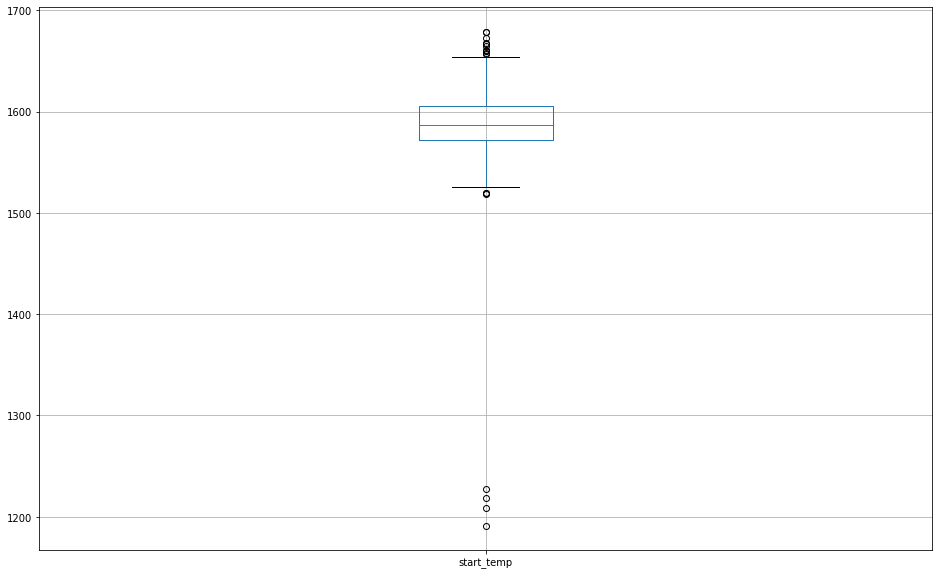

In [51]:
# изучим распределение данных
data_steel.boxplot(column='start_temp', figsize=(16,10))

<AxesSubplot:>

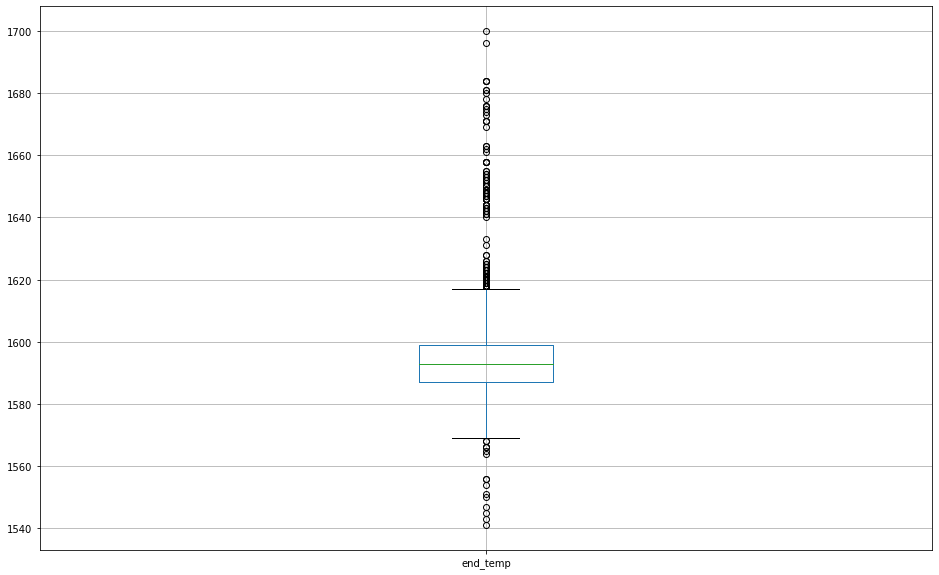

In [52]:
data_steel.boxplot(column='end_temp', figsize=(16,10))

<AxesSubplot:>

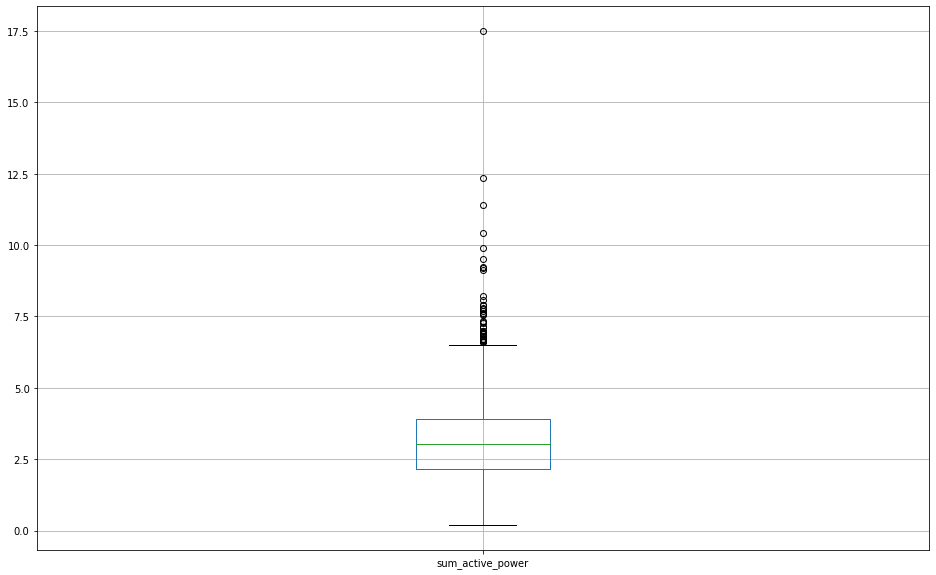

In [53]:
data_steel.boxplot(column='sum_active_power', figsize=(16,10))

<AxesSubplot:>

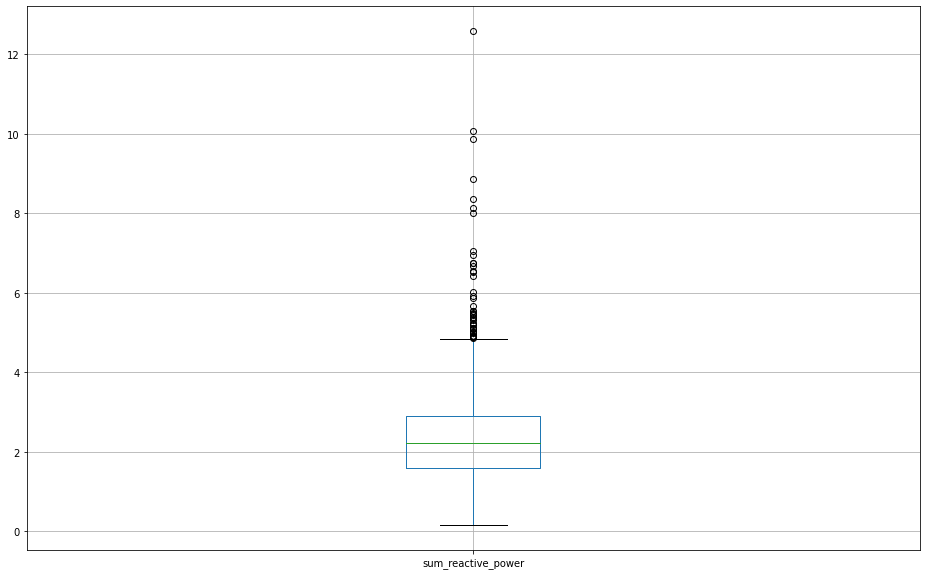

In [54]:
data_steel.boxplot(column='sum_reactive_power', figsize=(16,10))

<AxesSubplot:>

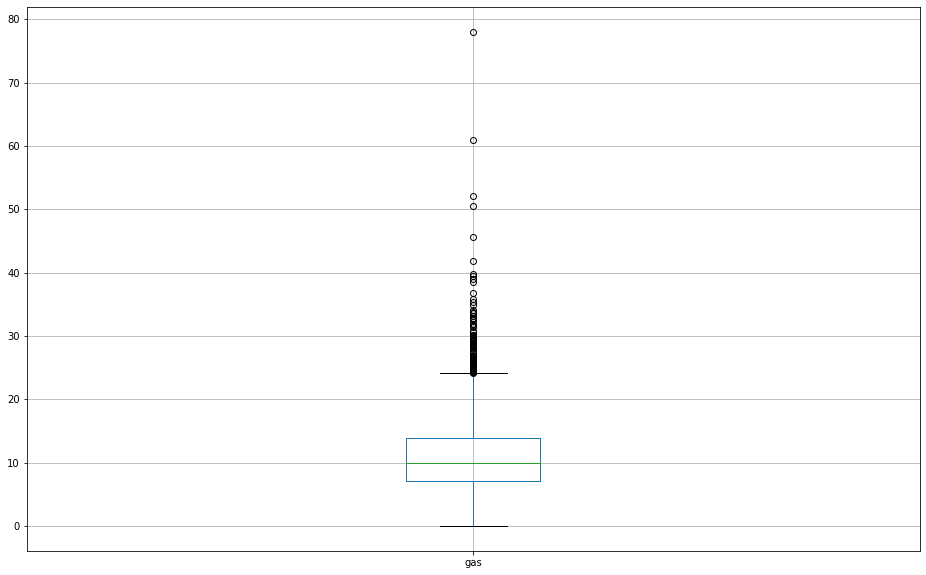

In [55]:
data_steel.boxplot(column='gas', figsize=(16,10))

>Выполним оценку мультиколлинеарности и отсутсвие зависимостей между целевым признаком и остальными.

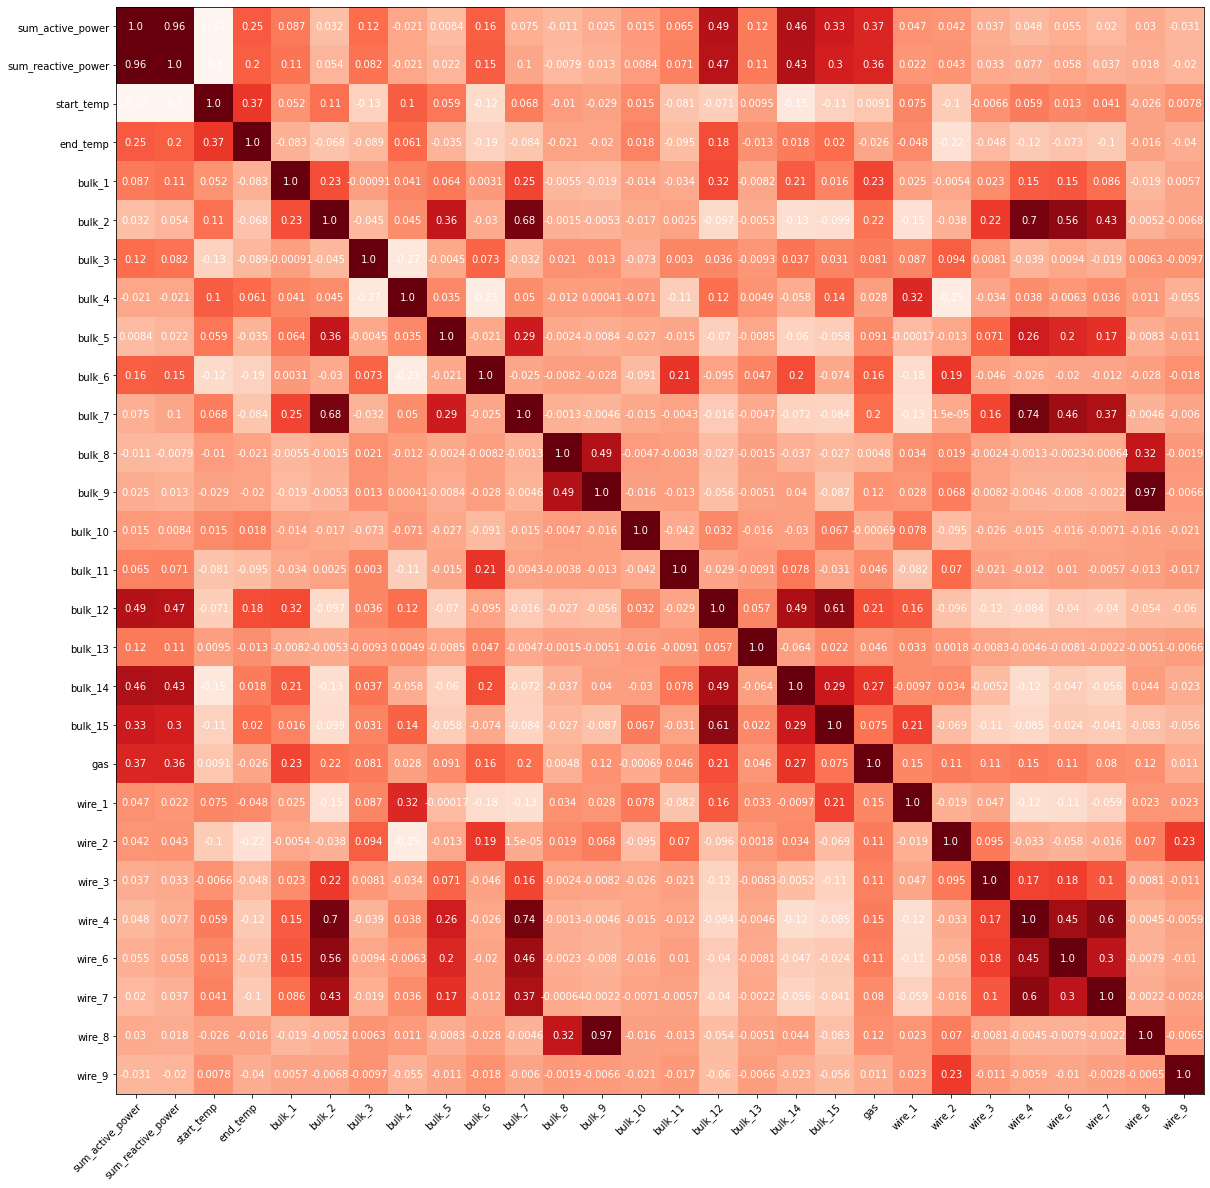

In [56]:
data_steel_knn = data_steel.copy()
corr_heatmap_data = data_steel_knn.corr()

fig, ax = plt.subplots(figsize=(20,20))
ax.set_xticks(np.arange(len(corr_heatmap_data.index)))
ax.set_yticks(np.arange(len(corr_heatmap_data.index)))

ax.set_xticklabels(corr_heatmap_data.index)
ax.set_yticklabels(corr_heatmap_data.index)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

data = corr_heatmap_data.values

for i in range(len(corr_heatmap_data.index)):
    for j in range(len(corr_heatmap_data.index)):
        text = ax.text(j, i, '{:.2}'.format(data[i, j]),
                       ha="center", va="center", color="w")
        
im = ax.imshow(corr_heatmap_data.corr(), cmap='Reds')

Из heatmap видно что есть сильные прямопропоциональные зависимости между sum_active_power и sum_reactive_power и bulk_9 и wire_8. Они по сути дублируют друг друга, удалим sum_reactive_power и wire_8.

In [57]:
data_steel_knn = data_steel_knn.drop(['sum_reactive_power', 'wire_8'], axis=1)

In [58]:
# посмотрим, какие столбцы влияют на результат end_temp
data_steel_knn.corr()['end_temp'] 

sum_active_power    0.247650
start_temp          0.366398
end_temp            1.000000
bulk_1             -0.082638
bulk_2             -0.067612
bulk_3             -0.088806
bulk_4              0.061157
bulk_5             -0.034697
bulk_6             -0.188054
bulk_7             -0.084039
bulk_8             -0.021390
bulk_9             -0.020254
bulk_10             0.018222
bulk_11            -0.095105
bulk_12             0.180171
bulk_13            -0.012884
bulk_14             0.017625
bulk_15             0.019843
gas                -0.025723
wire_1             -0.048129
wire_2             -0.215639
wire_3             -0.048014
wire_4             -0.121044
wire_6             -0.073452
wire_7             -0.100990
wire_9             -0.039511
Name: end_temp, dtype: float64

Как видно, не все столбцы значимо влияют на данные. Для выявления аномалий возьмем те, чья корреляция больше 10%.

In [59]:
data_steel_knn.corr()['end_temp'].abs() >= 0.1

sum_active_power     True
start_temp           True
end_temp             True
bulk_1              False
bulk_2              False
bulk_3              False
bulk_4              False
bulk_5              False
bulk_6               True
bulk_7              False
bulk_8              False
bulk_9              False
bulk_10             False
bulk_11             False
bulk_12              True
bulk_13             False
bulk_14             False
bulk_15             False
gas                 False
wire_1              False
wire_2               True
wire_3              False
wire_4               True
wire_6              False
wire_7               True
wire_9              False
Name: end_temp, dtype: bool

In [60]:
model = KNN()
data_steel_have_anomaly = data_steel_knn[['sum_active_power',
                                          'start_temp',
                                          'end_temp',
                                          'bulk_6',
                                          'bulk_12',
                                          'wire_2',
                                          'wire_4',
                                          'wire_7']]
model.fit(data_steel_have_anomaly)
data_steel_have_anomaly['is_outlier'] =  model.predict(data_steel_have_anomaly) == 1
outliers_knn = data_steel_have_anomaly['is_outlier'].sum()
print("Количество аномалий (KNN): ", outliers_knn)

outlier_indexes = list(data_steel_have_anomaly[data_steel_have_anomaly['is_outlier'] == 1].index)
good_indexes = list(set(data_steel_have_anomaly.index) - set(outlier_indexes))

data_steel_knn = data_steel_knn.drop(outlier_indexes)
data_steel_knn.shape

Количество аномалий (KNN):  196


(2148, 26)

### Вывод по пункту 2

- Удали все партии, где нет информации о температуре. 
- Удалили столбец wire_5 из-за отсуствия информации во всех записях.
- Изучили распределение данных.
- Целевым признаком определили столбец end_temp.
- Выполнили оценку мультиколлинеарности.
- Установили зависимости между sum_active_power и sum_reactive_power и bulk_9 и wire_8.
- Удалили sum_reactive_power и wire_8.

Подготовили данные для обучения модели.

## Обучение моделей

Разобьем данные на train и test к соотношению 75/25.


In [61]:
random_state = 12345
features = data_steel_knn.drop('end_temp', axis=1)
target = data_steel_knn['end_temp']

features_train, features_test, target_train, target_test = train_test_split(
                                                            features, 
                                                            target, 
                                                            test_size=0.25, 
                                                            random_state=random_state)
cv_counts = 5

Перед нами стоит задача регресии. Выберем следующие модели для обучения:

- LinearRegression
- RandomForestRegressor
- CatBoostRegressor
- LGBMRegressor
- XGBRegressor

Выполним поиск лучшей модели для предсказаний.

>**LinearRegression**

In [62]:
%%time

regressor = LinearRegression()
print('# Train for mean_absolute_error')
print()
cv_MAE_LR = (cross_val_score(regressor, 
                             features_train, 
                             target_train, 
                             cv=cv_counts, 
                             scoring='neg_mean_absolute_error').mean() * -1)
print('Mean MAE from CV of LinearRegression =', cv_MAE_LR)

# Train for mean_absolute_error

Mean MAE from CV of LinearRegression = 7.647884400270082
CPU times: user 122 ms, sys: 127 ms, total: 250 ms
Wall time: 229 ms


>**RandomForestRegressor**

In [63]:
%%time

regressor = RandomForestRegressor() 
hyperparams = [{'criterion':['mse'],
                'n_estimators':[x for x in range(100, 1001, 50)], 
                'random_state':[random_state]}]
# hyperparams = [{'criterion':['mse'],
#                 'n_estimators':[300], 
#                 'random_state':[random_state]}]

print('# Tuning hyper-parameters for mean_absolute_error')
print()
clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_absolute_error', cv=cv_counts)
clf.fit(features_train, target_train)
print("Best parameters set found on development set:")
print()
best_params_RFR = clf.best_params_
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1), params))
print()

cv_MAE_RFR = (max(means)*-1)

# Tuning hyper-parameters for mean_absolute_error

Best parameters set found on development set:

{'criterion': 'mse', 'n_estimators': 850, 'random_state': 12345}

Grid scores on development set:

6.155988 for {'criterion': 'mse', 'n_estimators': 100, 'random_state': 12345}
6.145319 for {'criterion': 'mse', 'n_estimators': 150, 'random_state': 12345}
6.146206 for {'criterion': 'mse', 'n_estimators': 200, 'random_state': 12345}
6.145505 for {'criterion': 'mse', 'n_estimators': 250, 'random_state': 12345}
6.135812 for {'criterion': 'mse', 'n_estimators': 300, 'random_state': 12345}
6.131557 for {'criterion': 'mse', 'n_estimators': 350, 'random_state': 12345}
6.129082 for {'criterion': 'mse', 'n_estimators': 400, 'random_state': 12345}
6.128503 for {'criterion': 'mse', 'n_estimators': 450, 'random_state': 12345}
6.132307 for {'criterion': 'mse', 'n_estimators': 500, 'random_state': 12345}
6.130404 for {'criterion': 'mse', 'n_estimators': 550, 'random_state': 12345}
6.131560 for {'criterio

>**CatBoostRegressor**

In [64]:
%%time

regressor = CatBoostRegressor(verbose=False, random_state=random_state)
print('# Train for mean_absolute_error')
print()
cv_MAE_CBR = (cross_val_score(regressor, 
                             features_train, 
                             target_train, 
                             cv=cv_counts, 
                             scoring='neg_mean_absolute_error').mean() * -1)
print('Mean MAE from CV of CatBoostRegressor =', cv_MAE_CBR)

# Train for mean_absolute_error

Mean MAE from CV of CatBoostRegressor = 5.859705871057433
CPU times: user 18.5 s, sys: 527 ms, total: 19.1 s
Wall time: 30.8 s


In [65]:
best_params_CBR = CatBoostRegressor(verbose=False, 
                                    random_state=random_state).fit(features_train, 
                                        target_train).get_all_params()
best_params_CBR

{'nan_mode': 'Min',
 'eval_metric': 'RMSE',
 'iterations': 1000,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': True,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': False,
 'random_seed': 12345,
 'depth': 6,
 'posterior_sampling': False,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'RMSE',
 'learning_rate': 0.04414699971675873,
 'score_function': 'Cosine',
 'task_t

>**LGBMRegressor**

In [66]:
%%time

regressor = LGBMRegressor() 
hyperparams = [{'num_leaves':[x for x in range(10,31)], 
                'learning_rate':[x/100 for x in range(1, 11)],
                'random_state':[random_state]}]
print('# Tuning hyper-parameters for mean_absolute_error')
print()
clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_absolute_error', cv=cv_counts)
clf.fit(features_train, target_train)
print("Best parameters set found on development set:")
print()
best_params_LGBMR = clf.best_params_
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1), params))
print()

cv_MAE_LGBMR = (max(means)*-1)

# Tuning hyper-parameters for mean_absolute_error

Best parameters set found on development set:

{'learning_rate': 0.08, 'num_leaves': 10, 'random_state': 12345}

Grid scores on development set:

7.599275 for {'learning_rate': 0.01, 'num_leaves': 10, 'random_state': 12345}
7.553269 for {'learning_rate': 0.01, 'num_leaves': 11, 'random_state': 12345}
7.509853 for {'learning_rate': 0.01, 'num_leaves': 12, 'random_state': 12345}
7.475853 for {'learning_rate': 0.01, 'num_leaves': 13, 'random_state': 12345}
7.450304 for {'learning_rate': 0.01, 'num_leaves': 14, 'random_state': 12345}
7.430315 for {'learning_rate': 0.01, 'num_leaves': 15, 'random_state': 12345}
7.413837 for {'learning_rate': 0.01, 'num_leaves': 16, 'random_state': 12345}
7.397704 for {'learning_rate': 0.01, 'num_leaves': 17, 'random_state': 12345}
7.372368 for {'learning_rate': 0.01, 'num_leaves': 18, 'random_state': 12345}
7.351331 for {'learning_rate': 0.01, 'num_leaves': 19, 'random_state': 12345}
7.340316 for {'learning

>**XGBRegressor**

In [67]:
%%time

regressor = XGBRegressor() 
hyperparams = [{'learning_rate':[x/100 for x in range(1, 51)],
                'random_state':[random_state],
                 'silent':[True]}]
print('# Tuning hyper-parameters for mean_absolute_error')
print()
clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_absolute_error', cv=cv_counts)
clf.fit(features_train, target_train)
print("Best parameters set found on development set:")
print()
best_params_XGBR = clf.best_params_
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1), params))
print()

cv_MAE_XGBR = (max(means)*-1)

# Tuning hyper-parameters for mean_absolute_error

[13:14:30] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[13:14:33] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[13:14:36] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or 

### Тестирование моделей

По условию задания MAE метрика качества модели:
- MAE > 8.7 минимальная метрика 
- MAE ≤ 6.0 максимальная метрика 


In [68]:
%%time

model = LinearRegression()
model.fit(features_train, target_train)
target_predict = model.predict(features_test)
test_MAE_LR = mean_absolute_error(target_predict, target_test)
print('MAE on test for LinearRegression =', test_MAE_LR)

MAE on test for LinearRegression = 6.703947948668365
CPU times: user 39 ms, sys: 40.4 ms, total: 79.4 ms
Wall time: 75.5 ms


In [69]:
%%time

model = RandomForestRegressor()
model.set_params(**best_params_RFR)
model.fit(features_train, target_train)
target_predict = model.predict(features_test)
test_MAE_RFR = mean_absolute_error(target_predict, target_test)
print('MAE on test of RandomForestRegressor =', test_MAE_RFR)

MAE on test of RandomForestRegressor = 5.578707415927264
CPU times: user 8.45 s, sys: 43.8 ms, total: 8.5 s
Wall time: 8.51 s


In [70]:
%%time

model = CatBoostRegressor(verbose=False)
model.set_params(**best_params_CBR)
model.fit(features_train, target_train)
target_predict = model.predict(features_test)
test_MAE_CBR = mean_absolute_error(target_predict, target_test)
print('MAE on test of CatBoostRegressor =', test_MAE_CBR)

MAE on test of CatBoostRegressor = 5.234014653424193
CPU times: user 2.9 s, sys: 113 ms, total: 3.01 s
Wall time: 4.01 s


In [71]:
%%time

model = LGBMRegressor()
model.set_params(**best_params_LGBMR)
model.fit(features_train, target_train)
target_predict = model.predict(features_test)
test_MAE_LGBMR = mean_absolute_error(target_predict, target_test)
print('MAE on test of LGBMRegressor =', test_MAE_LGBMR)

MAE on test of LGBMRegressor = 5.434725398583605
CPU times: user 448 ms, sys: 3.88 ms, total: 452 ms
Wall time: 374 ms


In [72]:
%%time

model = XGBRegressor()
model.set_params(**best_params_XGBR)
model.fit(features_train, target_train)
target_predict = model.predict(features_test)
test_MAE_XGBR = mean_absolute_error(target_predict, target_test)
print('MAE on test of XGBRegressor =', test_MAE_XGBR)

[13:31:42] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


MAE on test of XGBRegressor = 5.3069286
CPU times: user 3.34 s, sys: 22 ms, total: 3.36 s
Wall time: 3.33 s


In [73]:
# сравнительная таблица результатов моделей
index = ['LinearRegression',
         'RandomForestRegressor',
         'CatBoostRegressor',
         'LGBMRegressor',
         'XGBRegressor']
data = {'MAE CV':[cv_MAE_LR,
                     cv_MAE_RFR,
                     cv_MAE_CBR,
                     cv_MAE_LGBMR,
                     cv_MAE_XGBR],
        'MAE test':[test_MAE_LR,
                        test_MAE_RFR,
                        test_MAE_CBR,
                        test_MAE_LGBMR,
                        test_MAE_XGBR]}

scores_data = pd.DataFrame(data=data, index=index)
scores_data['MAE min'] = scores_data['MAE test'] <= 8.7
scores_data['MAE max'] = scores_data['MAE test'] <= 6
scores_data

,MAE CV,MAE test,MAE min,MAE max
LinearRegression,7.647884,6.703948,True,False
RandomForestRegressor,6.126648,5.578707,True,True
CatBoostRegressor,5.859706,5.234015,True,True
LGBMRegressor,5.926771,5.434725,True,True
XGBRegressor,5.925877,5.306929,True,True


## Общий вывод

<div style="border:solid green 2px; padding: 20px">
В ходе работы над проектом было выполнено:

1. Исследованы и подготовлены данные. Изменены типы данных, определены номера партий, у которых есть замеры по температуре.
2. Подготовлены признаки. Составлена единая таблица со всеми данными для модели. Выделен целевой признак - конечный замер температуры. Данные разделены на features и target со смешиванием данных.
3. Выбраны модели. Использованы и обучены модели регрессии.
4. Оценена эффективность моделей на тестовой выборке.

Лучшей моделью по метрике MAE = 5.23 стал CatBoostRegressor. Этот результат показывает, что модель в среднем ошибается на 5-6 градусов температуры. Другие модели RandomForestRegressor, LGBMRegressor и XGBRegressor получили решение идеальной задачи.
</div>      

In [75]:
#обозначим базовую модель 
model = CatBoostRegressor(verbose=0)

<AxesSubplot:>

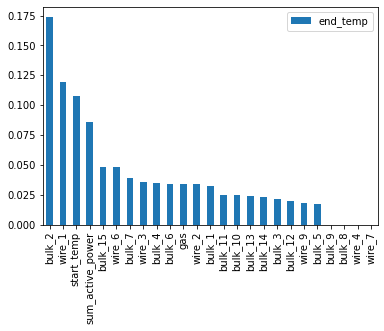

In [74]:
# построим график базовой модели
pd.DataFrame({'end_temp': model.feature_importances_}, index=features_test.columns).sort_values(by='end_temp', ascending=False).plot(kind='bar')

## План проекта

1. Обзор данных.
2. Первичный анализ данных.
3. Исследовательский анализ данных.
4. Подготовка данных.
4. Построение и обучение модели.
5. Общий вывод.
6. Отчет о проделанной работе.

Первый этап: необходимо разобраться с производственным процессом и с исходными данными, провести их первичный анализ (особенности, оценить аномалии, пропуски, адекватность). 

Второй этап: (работа с моделями) генерация и поиск бизнес-факторов для моделирования, проверка на мультиколлинеарность ДО моделирования и анализ важности факторов у модели-победителя, разбивка данных на train и test к соотношению 75/25, подбор самих моделей, показателей самих моделей, подбор параметров выбранных показателей у выбранных моделей.

Третий этап: общий вывод о проделанной работе.

Четвертый этап: отчет о проделанной работе.

## Отчет 

Задачей проекта было оптимизировать производственные расходы, металлургического комбината ООО «Так закаляем сталь» путем уменьшения потребления электроэнергии на этапе обработки стали. 

Цель проекта: построить модель, которая предскажет температуру стали.

- Какие пункты плана были выполнены, а какие — нет (поясните почему)?

В результате проведенной работы все пункты плана были выполнены. Цель проекта достигнута.

- Какие трудности возникли и как вы их преодолели?

Оснвная трудность заключалась на этапе анализа и обработки данных. Необходмо было разобраться в технологическом процессе производства стали, определить ключевые этапы, которые больше всего влияют на конечный результат, понять как правильно поступить с пропусками и разбросом в данных.

- Какие ключевые шаги в решении задачи выделили?

Ключевые шаги в решении задачи генерация и поиск бизнес-факторов для моделирования, проверка на мультиколлинеарность до моделирования и анализ важности факторов у модели-победителя, подбор самих моделей, показателей моделей, подбор параметров выбранных показателей у выбранных моделей.

Исходя из цели заказчика, искали способ точно предсказывать температуру. 
Судя по итоговой модели, самым важным фактором является первая температура. Это значит, что управляя ею, мы сможем управлять энергозатратами.

- Какая ваша итоговая модель и какое у неё качество?

Лучшая модель CatBoostRegressor метрика MAE = 5.23. 
